In [41]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.core.interactiveshell import InteractiveShell

from pandas.plotting import scatter_matrix

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import mean_squared_error

import lime
InteractiveShell.ast_node_interactivity = "all"

# Part 1
## Feature Engineering
### Load the data and split it
Initial loading of data<br>
Do not overwrite labels and features<br>
```data``` is available as a fresh copy always

In [101]:
filename = 'train.csv'
filepath = ''

data = pd.read_csv(filepath + filename)
labels = data['Y']
features = data.drop(['id', 'Y'], axis=1)

### Take a quick look

In [102]:
features.describe()
features.head()
#features.isnull().sum()
#print(features['F25'])
#features.dtypes

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
count,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,1.638300e+04,16383.000000,16383.000000,16383.000000,16383.000000,...,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,0.0,0.0,0.0
mean,44312.117256,26032.070927,0.048953,40.002991,121039.419459,6.272233e+03,201731.398767,1.043216,130602.569798,132923.113593,...,1.047183,118208.827077,1.043460,1.043277,127587.576634,1.042361,52450.117256,NaN,NaN,NaN
std,34815.325971,35742.773305,0.281347,4.998992,5802.987367,1.124685e+05,100732.735724,0.249209,31139.943666,6684.977553,...,0.285203,11021.402921,0.250144,0.268421,19031.948437,0.247142,34815.325971,NaN,NaN,NaN
min,999.000000,43.000000,0.000000,21.000000,118751.000000,1.000000e+03,15429.000000,1.000000,121980.000000,33778.000000,...,1.000000,5163.000000,1.000000,1.000000,13223.000000,1.000000,9137.000000,NaN,NaN,NaN
25%,21896.000000,4603.000000,0.000000,37.000000,119325.000000,1.000000e+03,130752.000000,1.000000,122624.000000,128299.000000,...,1.000000,118832.000000,1.000000,1.000000,126972.000000,1.000000,30034.000000,NaN,NaN,NaN
50%,36806.000000,13819.000000,0.000000,40.000000,119868.000000,1.000000e+03,143236.000000,1.000000,123581.000000,129069.000000,...,1.000000,119453.000000,1.000000,1.000000,127528.000000,1.000000,44944.000000,NaN,NaN,NaN
75%,75414.000000,41799.500000,0.000000,43.000000,120739.000000,2.000000e+03,303218.000000,1.000000,124514.000000,138298.000000,...,1.000000,119703.000000,1.000000,1.000000,129100.000000,1.000000,83552.000000,NaN,NaN,NaN
max,314150.000000,311733.000000,7.000000,59.000000,269481.000000,1.108900e+07,333172.000000,9.000000,317189.000000,306789.000000,...,13.000000,312049.000000,12.000000,8.000000,295412.000000,8.000000,322288.000000,NaN,NaN,NaN


,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
0,38733,61385,0,38,118751,1000,32020,1,121980,127959,...,1,118830,1,1,126461,1,46871,NaN,NaN,NaN
1,34248,51329,0,41,120800,1000,130630,1,124029,128342,...,1,118832,1,1,130296,1,42386,NaN,NaN,NaN
2,15830,5522,0,50,118779,1000,303218,2,122006,128299,...,1,118832,1,2,127063,1,23968,NaN,NaN,NaN
3,19417,6754,0,45,123163,2000,19024,1,126391,127968,...,1,118832,1,1,15274,1,27555,NaN,NaN,NaN
4,42122,16991,0,41,119193,1000,303218,1,122422,128299,...,1,118832,1,1,133491,1,50260,NaN,NaN,NaN


Immediately we see that the last three columns are all floats, but listed as NaN. These can all be safely deleted.

In [103]:
garbage = ['F25', 'F26', 'F27']
features.drop(garbage, axis=1, inplace=True)

### Look for Outliers

Lets make a quick scatter plot of each feature column

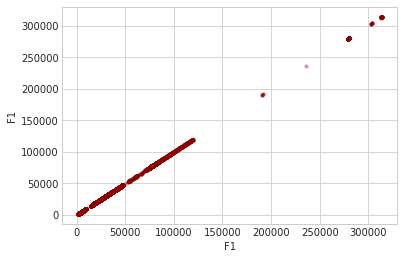

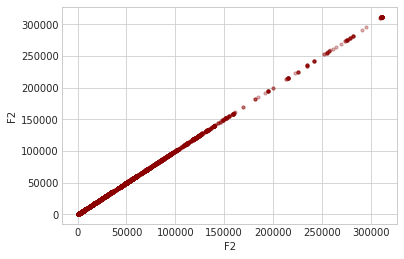

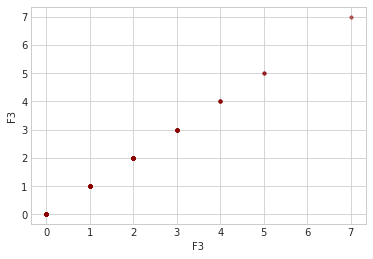

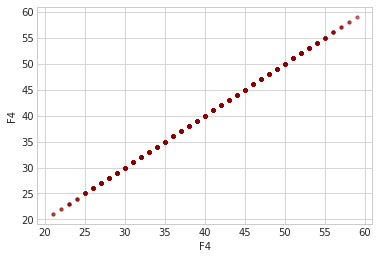

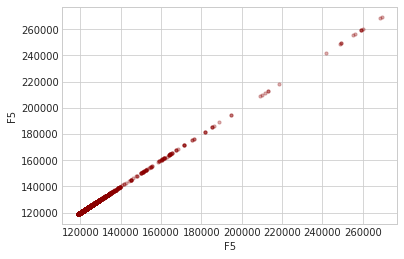

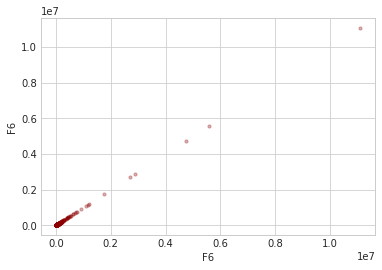

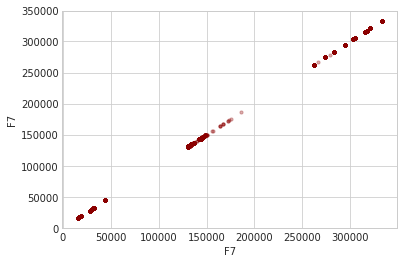

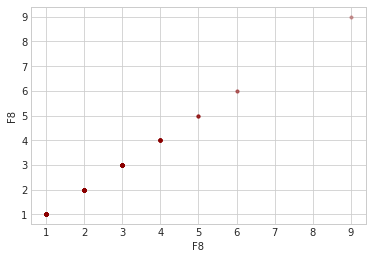

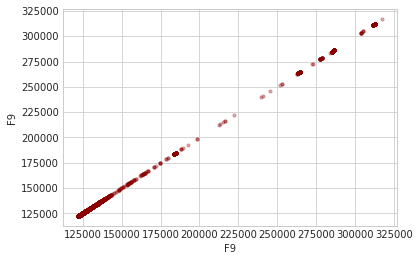

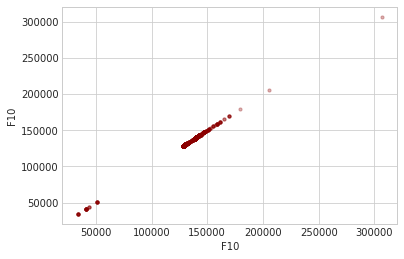

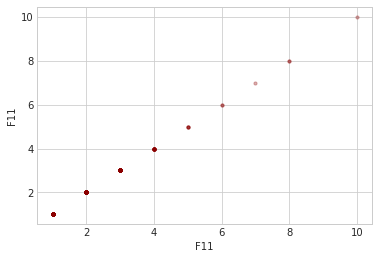

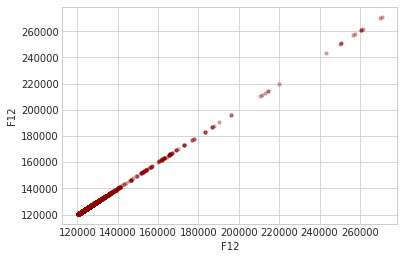

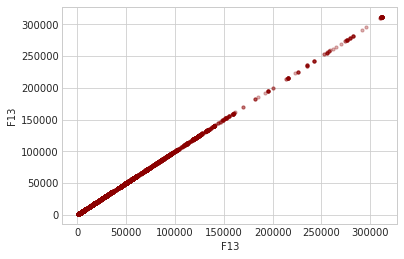

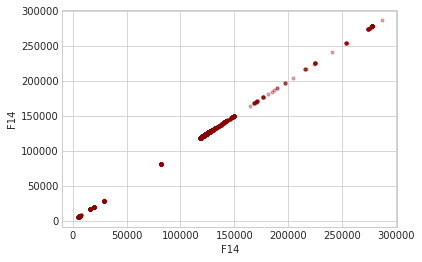

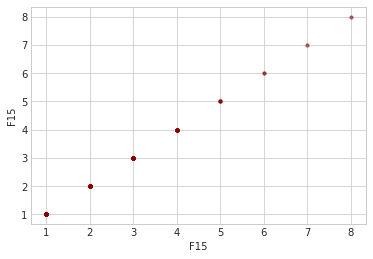

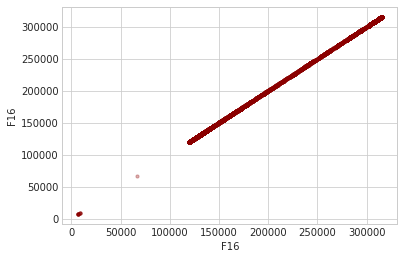

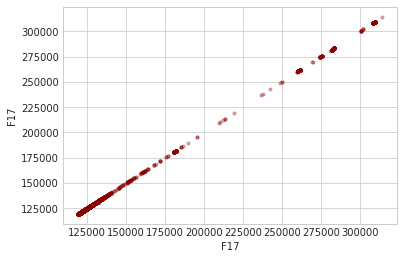

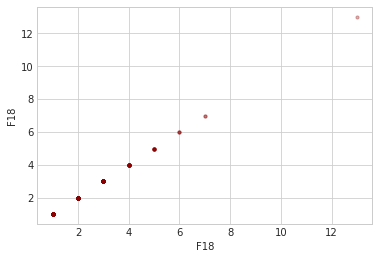

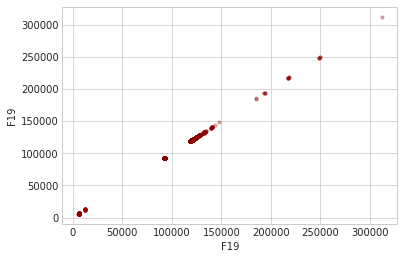

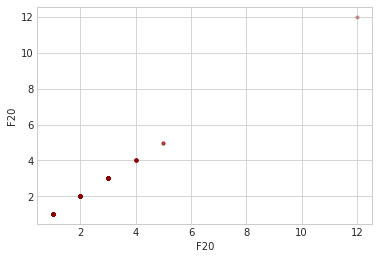

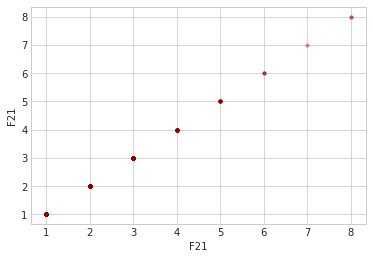

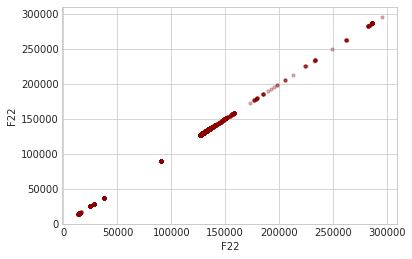

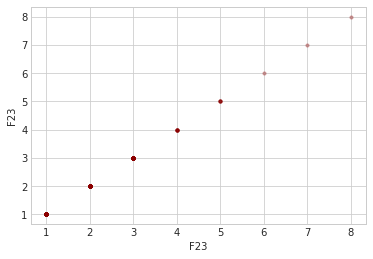

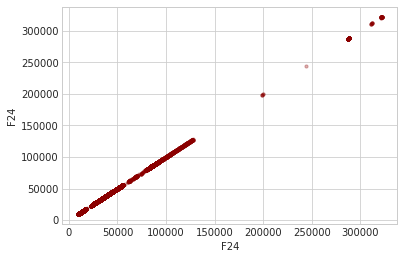

In [61]:

sb.set_style("whitegrid")
for column in features.columns:
    _ = sb.regplot(features[column], features[column], scatter_kws={"color":"darkred","alpha":0.3,"s":10}, fit_reg=False)
    plt.show()

We notice severe outliers in:<br>`F6`<br>`F16`<br>`F20`<br><br>
We notice moderate outliers in:<br>`F3`<br>`F5`<br>`F8`<br>`F18`<br>`F24`<br><br>
We notice odd groupings in <br>`F7`<br>`F10`<br>`F12`<br>`F19`<br>`F22`<br><br>
Lets remove the bad outliers, then investigate further.<br><br>
First, `F6`.


In [104]:
data_point = features['F6'].idxmax()
while features.iloc[data_point]['F6'] > 0.6*10**7:
    data_point = features['F6'].idxmax()
    features.drop([data_point], inplace=True)
    labels.drop([data_point], inplace=True)

#print(features.shape)
#print(labels.shape)

Now we remove the outliers from `F16`